# Reciever Operator Curve
<p>The Reciever Operator Curve is a useful tool for understanding how well a classification model ranks instances. <br><br> 

<b><u>Defining the ROC</u></b><br><br>
Assume some function $f(x)$ that gives real-valued output. We define a classifier based on $f(x)$ as the following:<br><br>
<center>$c(x) = I(f(x)\geq t)$</center><br><br>
for some constant $t$, and where $I(...)$ is the indicator function. For each threshold $t$ that is chosen, we can define two quantities: 1). The false positive rate, $FPR = \frac{False Positives}{False Positives+True Negatives}$, and 2). The true positive rate, $TPR = \frac{True Positives}{True Positives+False Negatives}$. The ROC is the result of plotting $FPR$ against $TPR$ for each value of $t$ that is possible in the data.<br><br>

<b><u>The Area Under the Curve</u></b><br><br>
The area under the curve captures the ROC information as a single metric. It is useful for both model and feature selection. With the ROC defined, we simply integrate across all values of FPR to get the area. <br><br>
<center>$AUC = \int_0^1 \: TPR \:dFPR$</center><br><br>

While this is the exact definition, and is how one might measure it empirically using numeric integration, it is not necessarily intuitive to think of a classifier in the $FPR$ domain. After all, we choose the threshold $t$ and not the $FPR$. We can get around this, but first lets define a few things. Let $s^+(v)$ and $s^-(v)$ be the PDF of $v=f(x)$ for positive and negative labeled examples, respectively. Similarly, let $S^+(v)$ and $S^-(v)$ be the CDF of $v=f(x)$ for positive and negative labeled labeled, respectively.
We can use these to define the $FPR$ and $TPR$ as functions of $t$.<br><br>

<center>$FPR(t) = \int_t^\infty \:s^-(v) \:dv=1-S^-(t)$</center>
<center>$TPR(t) = \int_t^\infty \:s^+(v) \:dv=1-S^+(t)$</center>


<br><br>
With $FPR$ and $TPR$ defined as functions of $t$, we can use the fact that $\frac{dFPR(t)}{dt}=-s^-(t)$
to show that:
<br><br>
<center>$AUC = \int_0^1 \: TPR(t) \:dFPR(t) =-\int_{\infty}^{-\infty} \:TPR(t) \:s^-(t)\:dt = \int_{-\infty}^{\infty} \:TPR(t) \:s^-(t)\:dt=\int_{-\infty}^{\infty}\:(1-S^+(t))\:s^-(t)\:dt$</center>

<br><br>
This last term expresess $AUC$ as a function of both the distribution of $f(x)$ for both positive and negative instances. This gives the AUC a probabilistic interpretation. ** For a given threshold $t$, we can choose one negative with a score exactly $t$. This has a probability of $s^-(t)$. The probability that a positive will have a score greater than this negative is $TPR(t)=1-S^+(t)$. If we repeat this exercise <font color = #dd4124> for every value of $t$, the probability that a randomly drawn positve instance has a higher score than a randomly drawn negative instance is then the $AUC$. </font> ** I.e.,<br><br>

<center>$AUC = P(f(x^+)>f(x^-)) = \int_{-\infty}^{\infty}\:P(f(x^-)=t)*P(f(x^+)\geq t)\:dt=\int_{-\infty}^{\infty}\:(1-S^+(t))\:s^-(t)\:dt$</center>
<br><br><br></p>

### Putting the ROC to Work

<p>
So that's enough theory for now, let's do a model bakeoff and show how the ROC can be used for model selection. First we'll build a model using four different algorithms and compare their ROCs.
</p>

In [1]:
#Build the datasets
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm, linear_model
from sklearn.neighbors import KNeighborsClassifier
import sys
#sys.path.append("C:/Users/kevin/Documents/GitHub/DS_course/ipython")
import course_utils as bd
import pandas as pd
import math
import numpy as np

import imp
imp.reload(bd)

#Load data and downsample for a 50/50 split, then split into a train/test
#f='C:/Users/kevin/Documents/GitHub/DS_course/datasets/ads_dataset_cut.txt'

train_split = 0.5
tdat = pd.read_csv('../data/ads_dataset_cut.txt',header=0,sep='\t')

lab = 'y_buy'

moddat = bd.downSample(tdat,lab,9)
#We know the dataset is sorted so we can just split by index
train = moddat[:int(math.floor(moddat.shape[0]*train_split))]
test = moddat[int(math.floor(moddat.shape[0]*train_split)):]

In [2]:
#Train the models
dt = DecisionTreeClassifier(criterion='entropy',min_samples_leaf = 10,max_depth = 4)
dt = dt.fit(train.drop(lab,1),train[lab])

lr = linear_model.LogisticRegression(C=1000)
lr.fit(train.drop(lab,1), train[lab])

mm = svm.SVC(kernel='linear', C=1)
mm.fit(train.drop(lab,1), 2*train[lab]-1)

knn = KNeighborsClassifier(n_neighbors=10, p=2)
knn.fit(train.drop(lab,1), train[lab])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

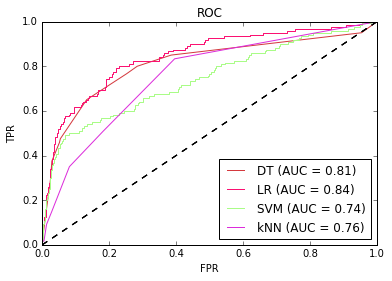

In [4]:
import matplotlib.pyplot as plt
% matplotlib inline
#plt.clf()

def plotAUC(truth, pred, lab):
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color=c, label= lab+' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")

plotAUC(test[lab], dt.predict_proba(test.drop(lab,1))[:,1], 'DT')
plotAUC(test[lab], lr.predict_proba(test.drop(lab,1))[:,1], 'LR')    
plotAUC(test[lab], mm.decision_function(test.drop(lab,1)), 'SVM')    
plotAUC(test[lab], knn.predict_proba(test.drop(lab,1))[:,1], 'kNN')    
plt.show()

<p>A calibration chart</p>


In [5]:
def getMAE(pred, truth):
    return np.abs(truth - pred).mean()

def getLL(pred, truth):
    ll_sum = 0
    for i in range(len(pred)):
        if (pred[i] == 0):
            p = 0.0001
        elif (pred[i] == 1):
            p = 0.9999
        else:
            p = pred[i]
        ll_sum += truth[i]*np.log(p)+(1-truth[i])*np.log(1-p)
    return (ll_sum)/len(pred)

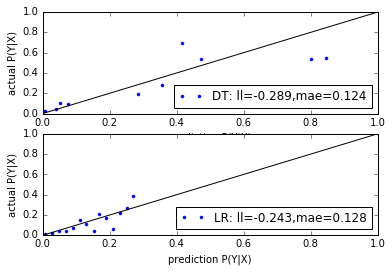

In [6]:

def plotCalib(truth, pred, bins, f, l):
    mae = np.round(getMAE(pred, truth),3)
    ll = np.round(getLL(pred, truth), 3)
    d = pd.DataFrame({'p':pred, 'y':truth})
    d['p_bin'] = np.floor(d['p']*bins)/bins
    d_bin=d.groupby(['p_bin']).agg([np.mean,len])
    filt = (d_bin['p']['len']>f)
    plt.plot(d_bin['p']['mean'][filt], d_bin['y']['mean'][filt], 'b.', label=l+': '+'ll={},mae={}'.format(ll,mae))
    plt.plot([0.0, 1.0], [0.0, 1.0], 'k-')
    #plt.title(label+':'+'MAE={}'.format(mae, ll))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('prediction P(Y|X)')
    plt.ylabel('actual P(Y|X)')
    plt.legend(loc=4)
    
plt.clf()
fig = plt.figure()
#plt.title('Calibration Charts for DT vs. LR')

ax = fig.add_subplot(2,1,1)
plotCalib(test[lab].values, dt.predict_proba(test.drop(lab,1))[:,1], 50, 10, 'DT')

ax = fig.add_subplot(2,1,2)
plotCalib(test[lab].values, lr.predict_proba(test.drop(lab,1))[:,1], 50, 10, 'LR')    

plt.show()



<p>Loop through features to get AUC and LL</p>

In [7]:
from sklearn.metrics import roc_auc_score

def evalFeat(x_train, y_train, x_test, y_test):
    lr_f = linear_model.LogisticRegression(C=1e30)
    lr_f.fit(x_train, y_train)
    p = lr_f.predict_proba(x_test)[:,1]
    ll = -1*getLL(p, y_test.values)
    auc = roc_auc_score(y_test, p)
    return [ll, auc]


lls = []
aucs = []
feats = train.drop(lab,1).columns.values
for f in feats:
    ll_f, auc_f = evalFeat(train[[f]], train[lab], test[[f]], test[lab])
    lls.append(ll_f)
    aucs.append(auc_f)




<p>A quick Lift chart</p>

In [7]:
def liftTable(pred, truth, b):
    df = pd.DataFrame({'p':pred+np.random.rand(len(pred))*0.000001,'y':truth})
    df['b'] = b - pd.qcut(df['p'], b, labels=False)
    df['n'] = np.ones(df.shape[0])
    df_grp = df.groupby(['b']).sum()
    base = np.sum(df_grp['y'])/float(df.shape[0])
    df_grp['n_cum'] = np.cumsum(df_grp['n'])/float(df.shape[0])
    df_grp['y_cum'] = np.cumsum(df_grp['y'])
    df_grp['p_y_b'] = df_grp['y']/df_grp['n']
    df_grp['lift_b'] = df_grp['p_y_b']/base
    df_grp['cum_lift_b'] = (df_grp['y_cum']/(float(df.shape[0])*df_grp['n_cum']))/base
    return df_grp
    

lifts_lr = liftTable(lr.predict_proba(test.drop(lab,1))[:,1], test[lab], 25)
#lifts_svm = liftTable(mm.decision_function(test.drop(lab,1)), test[lab], 25)
lifts_dt = liftTable(dt.predict_proba(test.drop(lab,1))[:,1]+np.random.rand(test.shape[0])*0.00001, test[lab], 25)
lifts_knn = liftTable(knn.predict_proba(test.drop(lab,1))[:,1], test[lab], 25)   




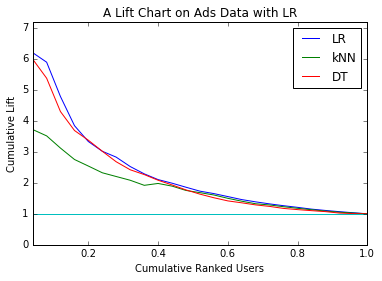

In [8]:
plt.title('A Lift Chart on Ads Data with LR')
plt.plot(lifts_lr['n_cum'], lifts_lr['cum_lift_b'], label='LR')
plt.plot(lifts_knn['n_cum'], lifts_knn['cum_lift_b'], label='kNN')
plt.plot(lifts_dt['n_cum'], lifts_dt['cum_lift_b'], label='DT')

plt.plot(lifts_lr['n_cum'], np.ones(lifts_lr.shape[0]))
plt.xlim([lifts_lr['n_cum'].min(), lifts_lr['n_cum'].max()])
plt.ylim([0.0, lifts_lr['cum_lift_b'].max()+1])
plt.xlabel('Cumulative Ranked Users')
plt.ylabel('Cumulative Lift')
plt.legend()

plt.show()
